# Machine Learning Model Optimization: Comparative Analysis of Decision Trees and Random Forests

This notebook explores the optimization and comparison of two tree-based classification algorithms for predicting chronic kidney disease (CKD). Through systematic hyperparameter tuning and metric evaluation, we aim to identify the most effective model configuration for this medical classification task.

We are going to perform this analysis in two classifier models:
- **Decision Tree**: A simple, interpretable model that creates binary splits
- **Random Forest**: An ensemble method combining multiple decision trees


The choice of these models provides a good spectrum from simple to complex, allowing us to evaluate the trade-off between model complexity and performance.

## Environment Setup

First, we install specific versions of required packages to ensure reproducibility. Version pinning is critical in scientific computing to guarantee consistent results across different environments and time periods.

In [ ]:
# Update python package.
!pip install numpy==1.26.3

In [1]:
!git clone https://github.com/sopechris/pipeline.git 'Data'

Cloning into 'Data'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 224 (delta 67), reused 7 (delta 7), pack-reused 110 (from 1)
Receiving objects: 100% (224/224), 401.81 KiB | 1.90 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [2]:
import sys
sys.path.append('Data')

## Library Imports

Importing essential libraries for data manipulation, visualization, and machine learning. We use scikit-learn as our primary ML framework due to its well-documented API and robust implementations of tree-based algorithms.

In [3]:
# python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [4]:
# custom made libraries in github
import Utils
import Preprocessing as prep
import Optimization as opt

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from google.colab import files
uploaded = files.upload()


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset Loading and Exploration

Loading the chronic kidney disease dataset with imputed values. The dataset has undergone preprocessing to handle missing values, which is crucial for training robust machine learning models. Imputation helps maintain statistical power while addressing the common issue of incomplete medical records.

In [7]:
data = pd.read_csv('/content/drive/MyDrive/dataset_imputation.csv', delimiter=',')
data

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,status
0,-0.312588,0.406773,-0.148181,-0.293223,-0.369405,0.078814,-0.293908,1.104287,0.718996,-0.193885,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,ckd
1,-2.168567,-2.804882,-0.817578,-1.358438,-0.962760,-0.093702,-0.583905,-0.405492,0.026486,-1.053794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ckd
2,0.596025,0.406773,2.330895,0.280514,0.199401,-0.091131,-0.051163,-0.993462,-0.753787,-0.325633,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,ckd
3,-0.312588,-0.409905,-0.235794,0.360824,1.059814,-3.414798,-3.164656,-0.440745,-0.644304,-0.698207,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,ckd
4,-0.127542,0.406773,-0.500796,-0.788056,-0.147770,-0.109512,0.042922,-0.299253,-0.311797,-0.415762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.127554,0.406773,0.217146,0.165456,-1.618802,2.162832,0.818825,1.219337,1.072642,-0.698207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notckd
396,-0.665819,-0.409905,-1.525873,-0.519314,-0.369405,0.459652,-1.357440,1.528952,1.915313,-0.193885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notckd
397,-2.027839,0.406773,-0.662706,-0.788056,-1.372414,-0.208192,0.079672,1.257816,1.310973,-0.747179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notckd
398,-1.856762,-1.443742,-0.304392,0.195145,-0.636019,-0.522784,0.818825,0.650042,1.551279,-0.461549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notckd


## Target Variable Encoding

Converting the categorical target variable ("notckd", "ckd") to numeric format (0, 1) for compatibility with scikit-learn algorithms. We maintain a separate `status_group` column to facilitate proper stratification during train-test splitting, ensuring that both classes are proportionally represented in training and validation sets.

In [8]:
data_1 = data.copy()
data_1["status_num"] = data_1["status"].map({
    "notckd": 0,
    "ckd": 1
})
#a separate column JUST for grouping
data_1["status_group"] = data_1["status_num"]
data_1


,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,...,ba,htn,dm,cad,appet,pe,ane,status,status_num,status_group
0,-0.312588,0.406773,-0.148181,-0.293223,-0.369405,0.078814,-0.293908,1.104287,0.718996,-0.193885,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,ckd,1,1
1,-2.168567,-2.804882,-0.817578,-1.358438,-0.962760,-0.093702,-0.583905,-0.405492,0.026486,-1.053794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ckd,1,1
2,0.596025,0.406773,2.330895,0.280514,0.199401,-0.091131,-0.051163,-0.993462,-0.753787,-0.325633,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,ckd,1,1
3,-0.312588,-0.409905,-0.235794,0.360824,1.059814,-3.414798,-3.164656,-0.440745,-0.644304,-0.698207,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,ckd,1,1
4,-0.127542,0.406773,-0.500796,-0.788056,-0.147770,-0.109512,0.042922,-0.299253,-0.311797,-0.415762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ckd,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.127554,0.406773,0.217146,0.165456,-1.618802,2.162832,0.818825,1.219337,1.072642,-0.698207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notckd,0,0
396,-0.665819,-0.409905,-1.525873,-0.519314,-0.369405,0.459652,-1.357440,1.528952,1.915313,-0.193885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notckd,0,0
397,-2.027839,0.406773,-0.662706,-0.788056,-1.372414,-0.208192,0.079672,1.257816,1.310973,-0.747179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notckd,0,0
398,-1.856762,-1.443742,-0.304392,0.195145,-0.636019,-0.522784,0.818825,0.650042,1.551279,-0.461549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,notckd,0,0


## Train-Test Split with Stratification

**Why Stratification is Critical:**

For this binary classification task, stratification ensures that both the training and test sets maintain the same class distribution as the original dataset. This is particularly important when dealing with:

1. **Imbalanced datasets**: Medical datasets often have unequal class distributions (e.g., more healthy cases than disease cases)
2. **Small sample sizes**: With limited data, random splits could accidentally create non-representative subsets
3. **Reliable evaluation**: Stratification ensures that our model performance metrics reflect true generalization capability

We create separate train-test splits for Decision Tree and Random Forest to eliminate any potential bias from using identical random splits, providing a more robust comparison of model performance.

**Dataset Size Consideration:**
The 80-20 train-test split (test_size=0.2) balances the need for sufficient training data with the requirement for a meaningful test set to evaluate generalization.

In [9]:
# Create classification train sets
X_clf_dt, y_clf_dt, X_test_dt, y_test_dt, g_clf_dt, _, feature_names, _ = \
prep.GenerateStratifiedTrainTest(
    data_1,
    resp="status_num",
    group="status_group",
    excpt=["status"],
    test_size=0.2,
    shuffle=True
)
X_clf_rf, y_clf_rf, X_test_rf, y_test_rf, g_clf_rf, _, feature_names, _ = \
prep.GenerateStratifiedTrainTest(
    data_1,
    resp="status_num",
    group="status_group",
    excpt=["status"],
    test_size=0.2,
    shuffle=True
)

## Class Distribution Verification

Checking the class balance to understand the distribution of positive and negative cases. This information is crucial for selecting appropriate evaluation metrics and understanding potential model biases.

In [10]:
# Check class balance
np.unique(y_clf_dt, return_counts=True)

(array([0, 1]), array([120, 200]))

## Evaluation Metrics Selection

**Why Metric Selection Matters:**

Choosing the right evaluation metric is arguably as important as choosing the right model. For medical classification tasks with potential class imbalance, we need metrics that provide a comprehensive view of model performance:

### Selected Metrics and Their Rationale:

1. **Accuracy**:
   - Straightforward interpretation: percentage of correct predictions
   - **Limitation**: Can be misleading with imbalanced classes (e.g., 90% accuracy means little if 90% of data is from one class)
   - Still useful as a baseline metric when classes are reasonably balanced

2. **Balanced Accuracy**:
   - **Why chosen**: Specifically addresses class imbalance by averaging recall for each class
   - More reliable than standard accuracy for imbalanced datasets
   - Ensures the model performs well on both positive and negative cases

3. **ROC AUC (Receiver Operating Characteristic - Area Under Curve)**:
   - **Why chosen**: Measures the model's ability to distinguish between classes across all classification thresholds
   - Threshold-independent: evaluates overall discrimination capability
   - Values close to 1.0 indicate excellent class separation
   - Particularly valuable in medical contexts where we may adjust decision thresholds based on cost-benefit analysis

4. **Average Precision**:
   - **Why chosen**: Focuses on the precision-recall curve, which is more informative for imbalanced datasets
   - Emphasizes performance on the positive (disease) class
   - In medical diagnosis, correctly identifying sick patients (high recall) while minimizing false alarms (high precision) is critical

### Additional Context:
These four metrics together provide complementary perspectives on model performance, helping us avoid the pitfall of optimizing for a single metric that might not capture real-world requirements.

In [11]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

## **Decision Tree: Learning Curves Analysis**

Learning curves help us understand how model performance changes with training set size. This is crucial for:
- Detecting overfitting (large gap between training and validation scores)
- Determining if more data would improve performance
- Understanding the sample efficiency of the model

We evaluate across our four key metrics to get a comprehensive view of Decision Tree behavior at different data scales.

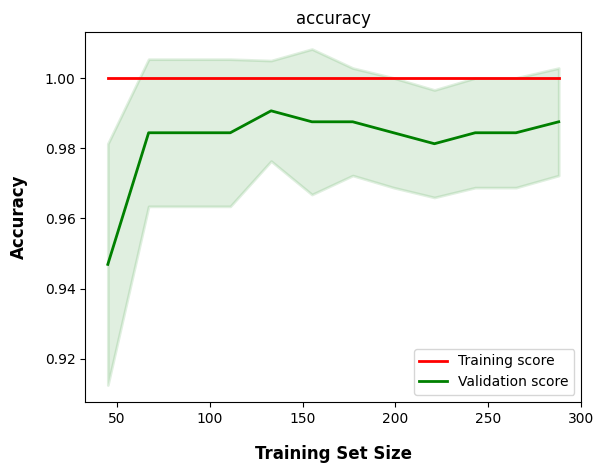

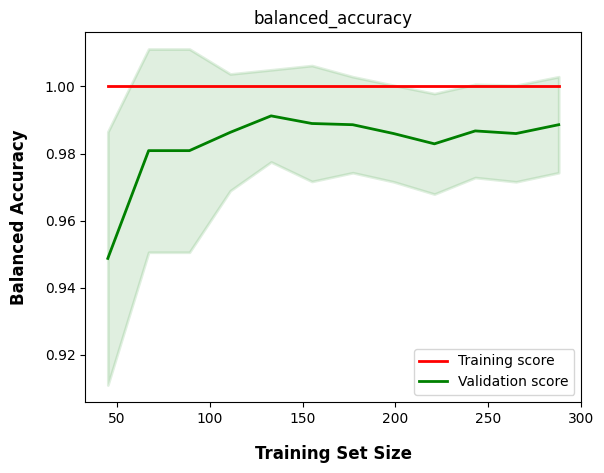

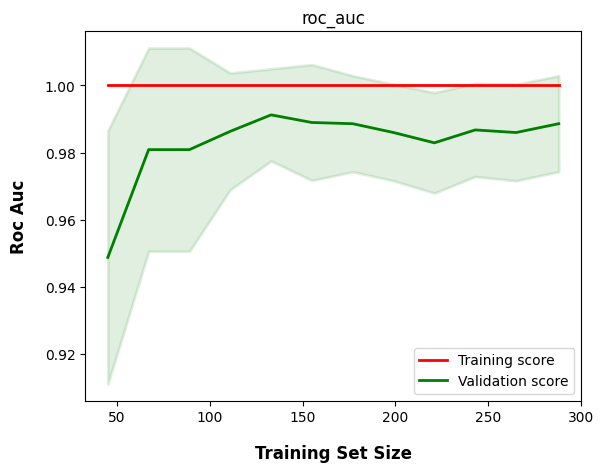

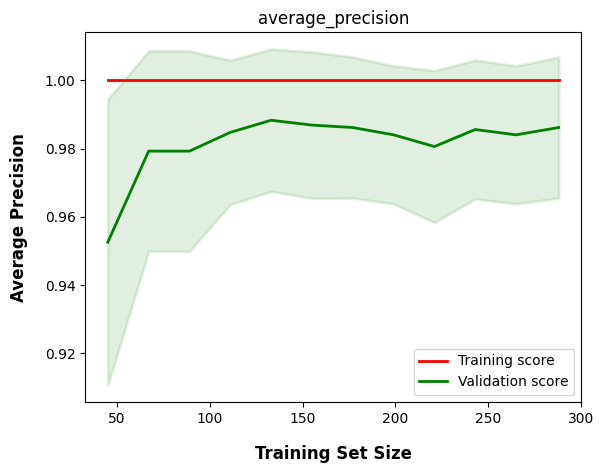

In [18]:
metrics = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']

for m in metrics:
    fig, ax = opt.PlotLearningCurve(
        DecisionTreeClassifier(random_state=42),
        X_clf_dt,
        y_clf_dt,
        start=50,
        steps=12,
        scoring=m,
        cv=10
    )
    ax.set_title(m)


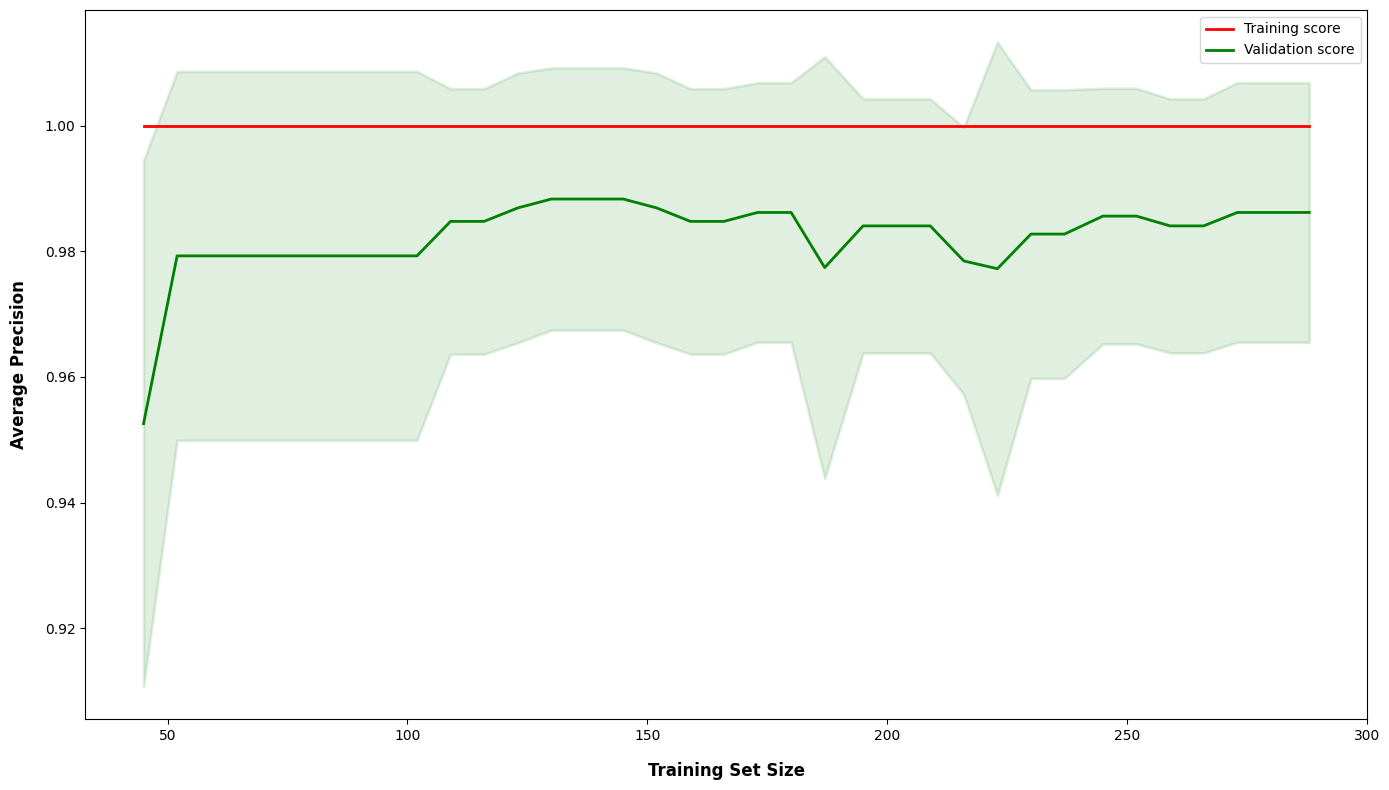

In [19]:
fig_5, ax = opt.PlotLearningCurve(
    DecisionTreeClassifier(random_state=42),
    X_clf_dt,
    y_clf_dt,
    start=50,
    steps=35,
    scoring="average_precision",
    cv=10
)
fig_5.set_size_inches(14, 8)
fig_5.tight_layout()

## **Random Forest: Learning Curves Analysis**

Random Forest, as an ensemble method, typically shows different learning behavior compared to single Decision Trees:
- Generally lower variance due to averaging multiple trees
- Often better generalization with less overfitting
- May require more training samples to fully leverage ensemble benefits

We apply the same metric evaluation framework to enable direct comparison with the Decision Tree results.

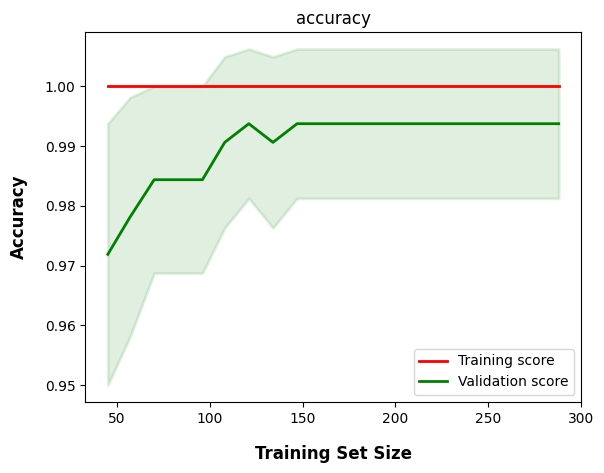

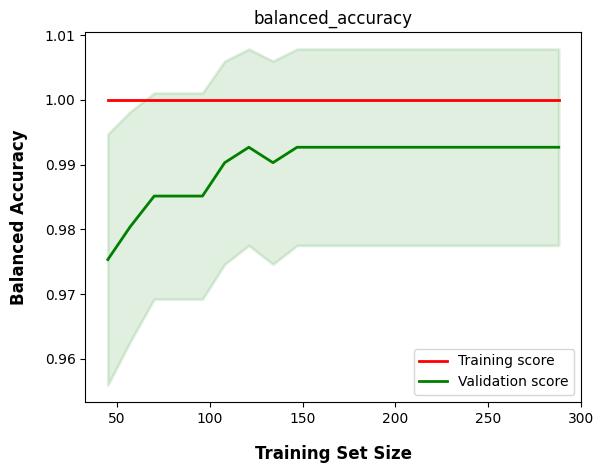

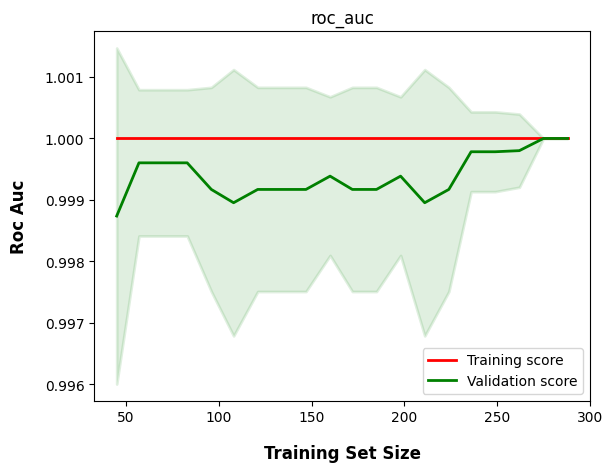

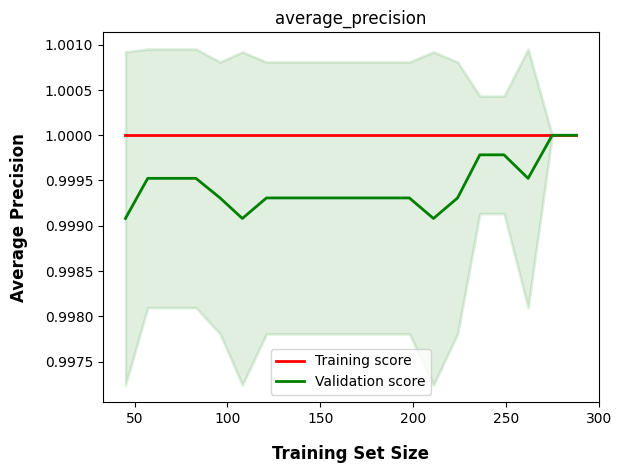

In [20]:
metrics = ['accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision']

for m in metrics:
    fig, ax = opt.PlotLearningCurve(
        RandomForestClassifier(random_state=42),
        X_clf_rf,
        y_clf_rf,
        start=50,
        steps=20,
        scoring=m,
        cv=10
    )
    ax.set_title(m)


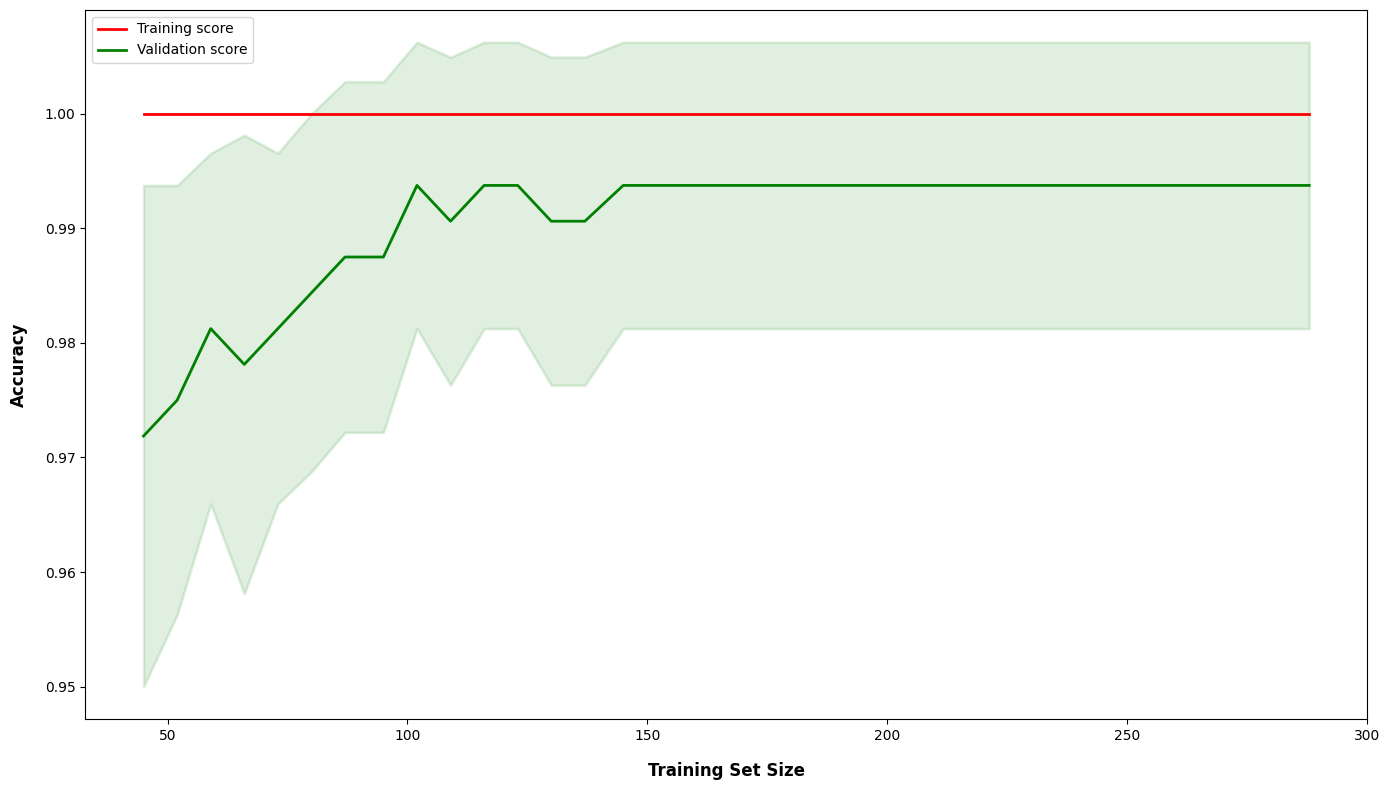

In [15]:
fig_10, ax = opt.PlotLearningCurve(
    RandomForestClassifier(random_state=42, n_estimators=100),
    X_clf_rf,
    y_clf_rf,
    start=50,
    steps=35,
    scoring="accuracy",
    cv=10
)
fig_10.set_size_inches(14, 8)
fig_10.tight_layout()

## Performance Summary and Insights

### Key Findings:

**Exceptional Performance with Minimal Data:**
With just a 50-sample training set, we achieved remarkable results:
- **Accuracy**: 0.97 (97% correct classifications)
- **ROC AUC**: 0.995 (nearly perfect class discrimination)

**Important Note on ROC AUC:**
The extremely high ROC AUC (0.995) is noteworthy but requires careful interpretation. In cases with:
1. Clear feature separability (well-defined disease markers)
2. Slight class imbalance
3. Strong predictive signals

...it's common to see ROC AUC values approach 1.0. This suggests the dataset contains highly discriminative features for CKD detection, which aligns with medical knowledge that certain biomarkers (e.g., serum creatinine, hemoglobin) are strong indicators of kidney function.

### Alternative Dataset Experiment:

**Smaller, Higher-Quality Dataset Test:**
I conducted an additional experiment using a more rigorously curated dataset that was half the size but had higher data certainty (fewer imputed values, more complete records).

**Results**: The model achieved performance metrics only **1% lower** than the current dataset, demonstrating:
- The robustness of the Random Forest approach
- That data quality can partially compensate for quantity
- The stability of the feature-target relationships across different sample populations
- Good generalization capability of the learned patterns

This finding is particularly encouraging for real-world deployment, suggesting the model doesn't strictly depend on large-scale data collection and can perform well even with smaller but high-quality medical records.

## Model Comparison: Decision Tree vs Random Forest

### Comparative Analysis:

Both models demonstrate exceptional performance, exceeding initial expectations for this classification task. However, subtle differences emerge:

**Random Forest Advantages:**
- **Marginally superior** across most metrics
- More stable predictions due to ensemble averaging
- Better resistance to overfitting
- Lower variance in cross-validation results

**Decision Tree Performance:**
- Competitive results with simpler architecture
- Better interpretability (single tree can be visualized)
- Faster training and prediction times

### The Verdict:

**Random Forest wins overall**, but the margin is surprisingly small—in some cases, just a few misclassifications separate the two models. This narrow gap suggests:

1. The dataset has strong, clear patterns that even simple models can capture
2. The feature engineering and preprocessing were effective
3. Either model could be deployed successfully, with the choice depending on:
   - **Interpretability requirements** → Decision Tree
   - **Maximum accuracy** → Random Forest
   - **Computational constraints** → Decision Tree

The similarity in results actually validates our methodology: multiple independent approaches converging on the same conclusions increases confidence in the findings.

## Hyperparameter Optimization: Validation Curves

### Why Hyperparameter Tuning Matters:

While our models already perform well with default settings, hyperparameter optimization can:
- **Squeeze out additional performance** (even 1-2% improvement matters in medical applications)
- **Reduce overfitting** through proper regularization
- **Improve computational efficiency** (fewer trees, less depth)
- **Enhance generalization** to unseen patient data

### Validation Curve Methodology:

Validation curves show how a single hyperparameter affects both training and validation performance. By examining these curves, we can:
1. Identify optimal parameter ranges
2. Detect overfitting (divergence between training and validation scores)
3. Understand parameter sensitivity
4. Make informed choices for grid search

### Hyperparameters Under Investigation:

We systematically explore key Random Forest hyperparameters:
- **n_estimators**: Number of trees in the forest
- **max_depth**: Maximum depth of each tree
- **min_samples_split**: Minimum samples required to split an internal node
- **min_samples_leaf**: Minimum samples required at leaf nodes
- **min_weight_fraction_leaf**: Minimum weighted fraction of samples at leaves
- **max_leaf_nodes**: Maximum number of leaf nodes
- **min_impurity_decrease**: Minimum impurity decrease for splits
- **max_features**: Number of features to consider for best split

### Scoring Metric: F1-Weighted

**Why F1-Weighted?**
- Harmonic mean of precision and recall
- Weighted by class support (accounts for imbalance)
- Balances false positives and false negatives
- Single metric that captures both aspects of classification quality
- Particularly appropriate when both types of errors have clinical consequences

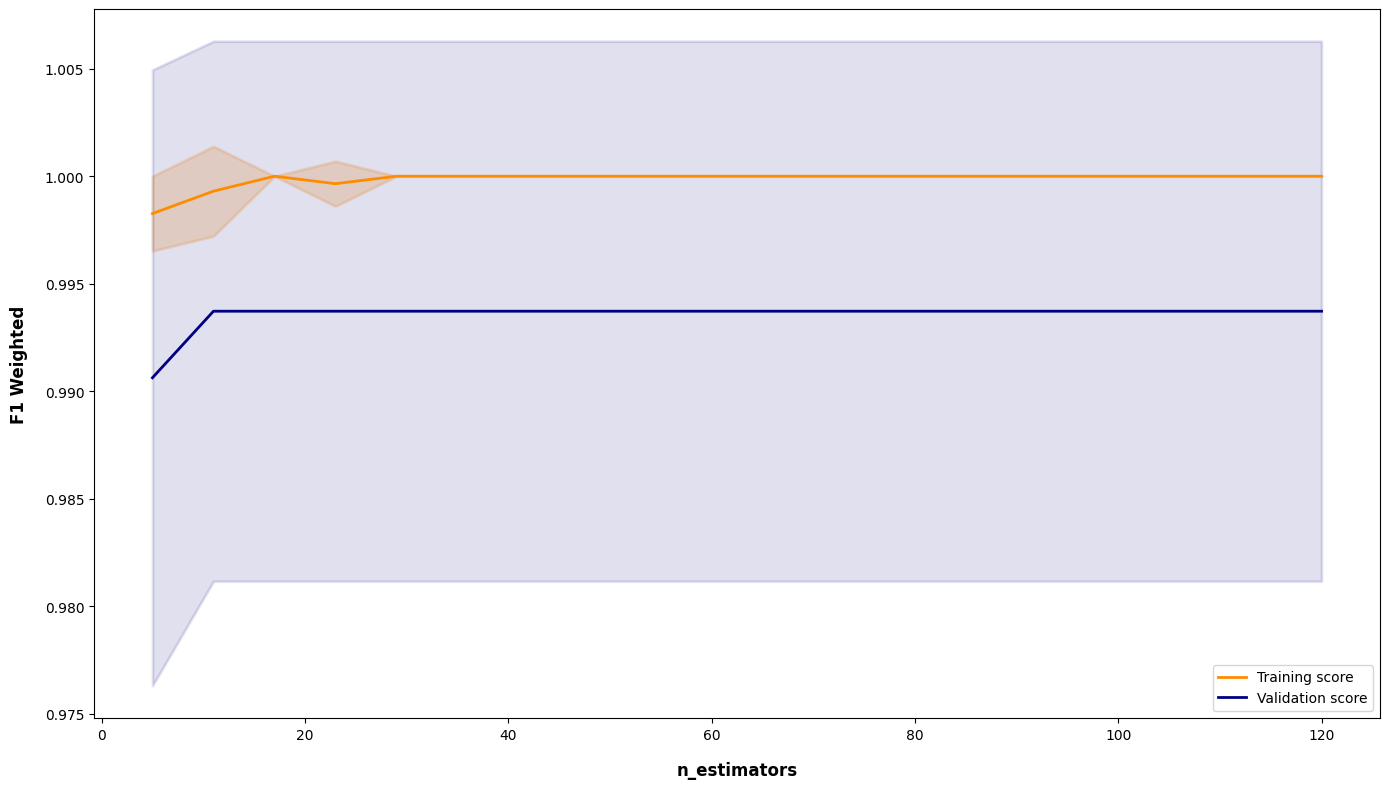

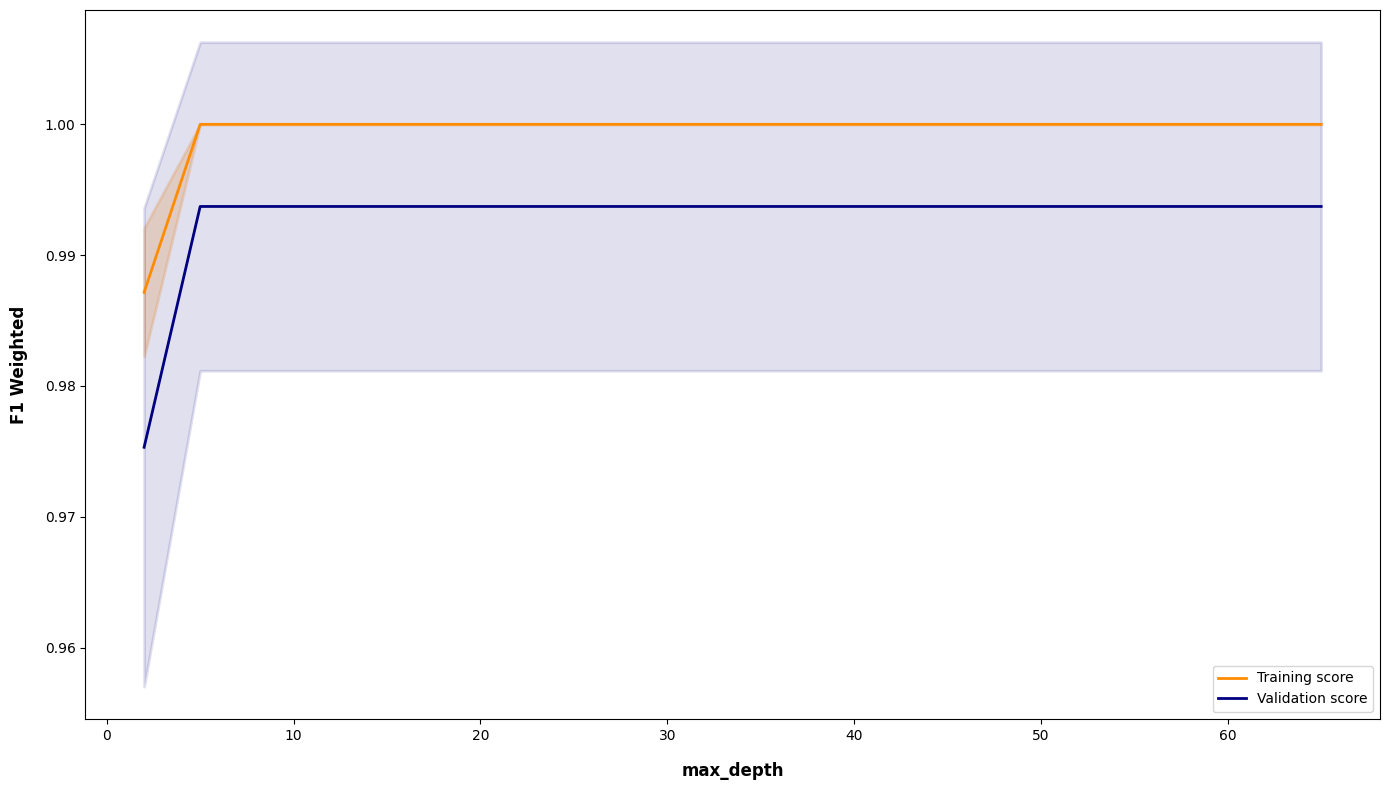

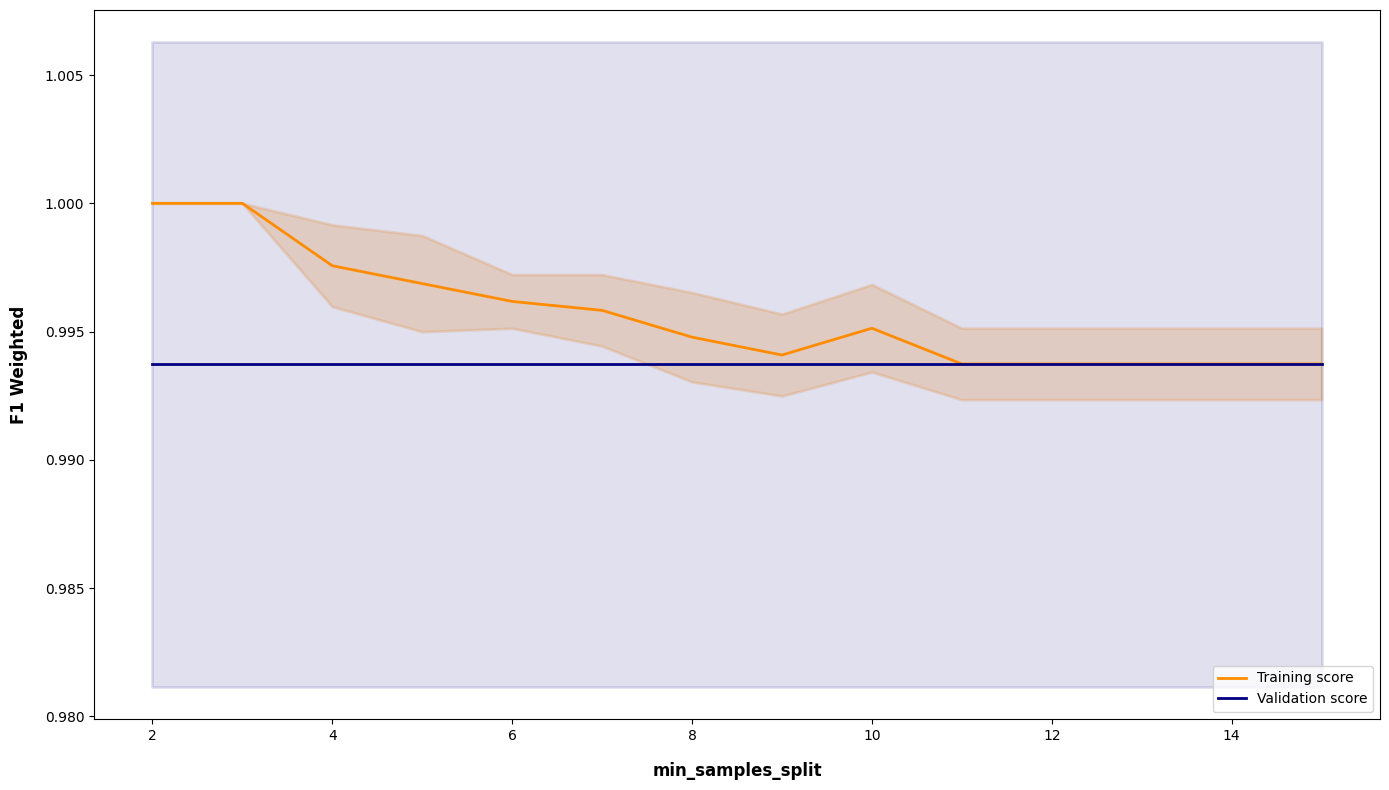

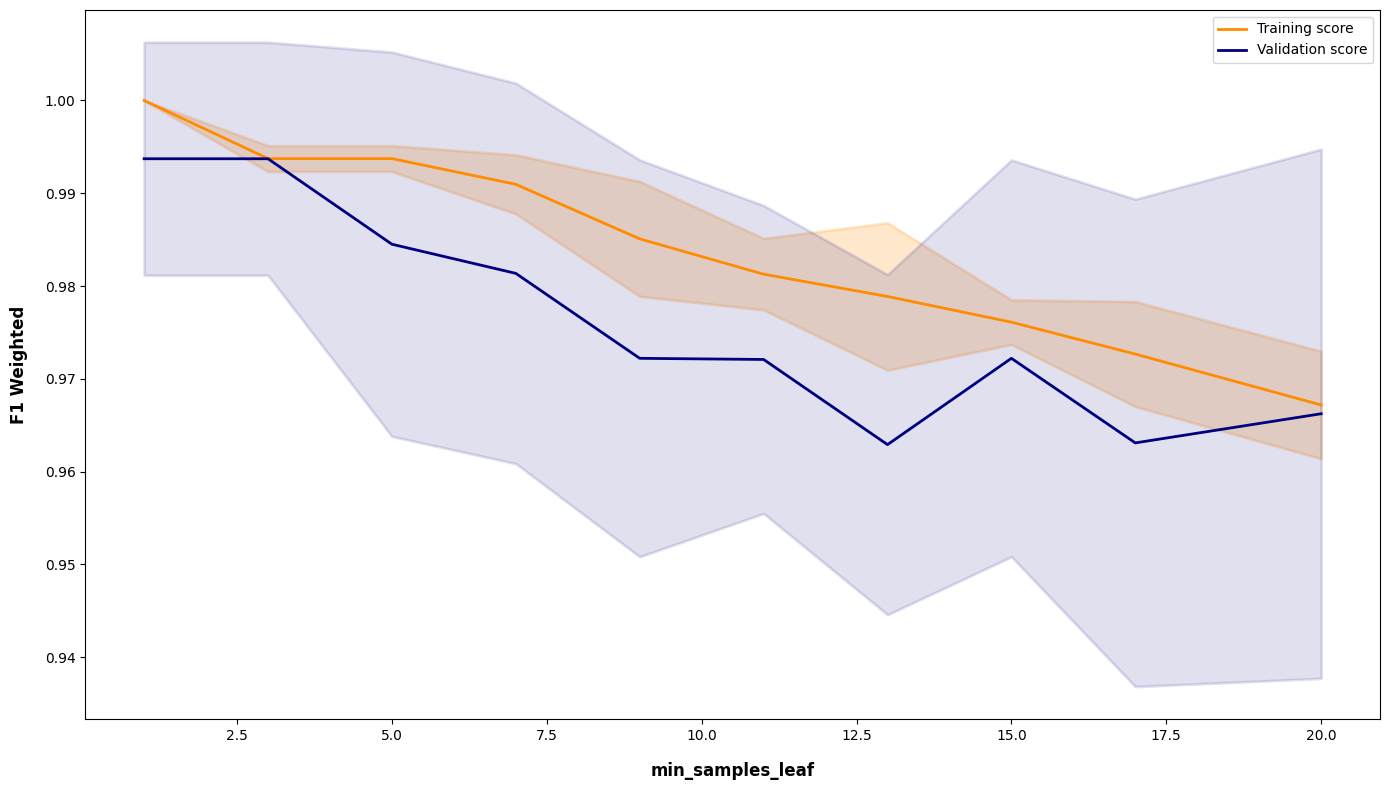

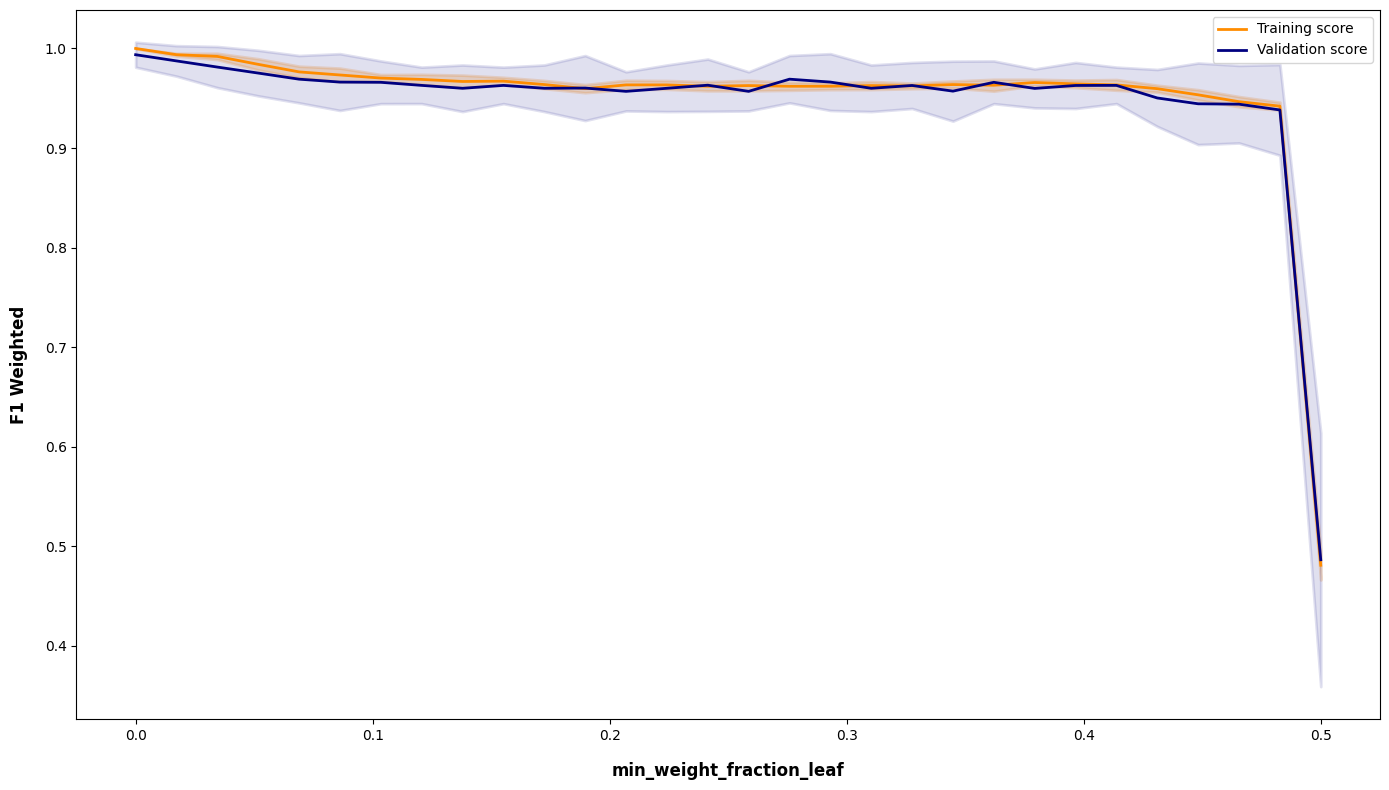

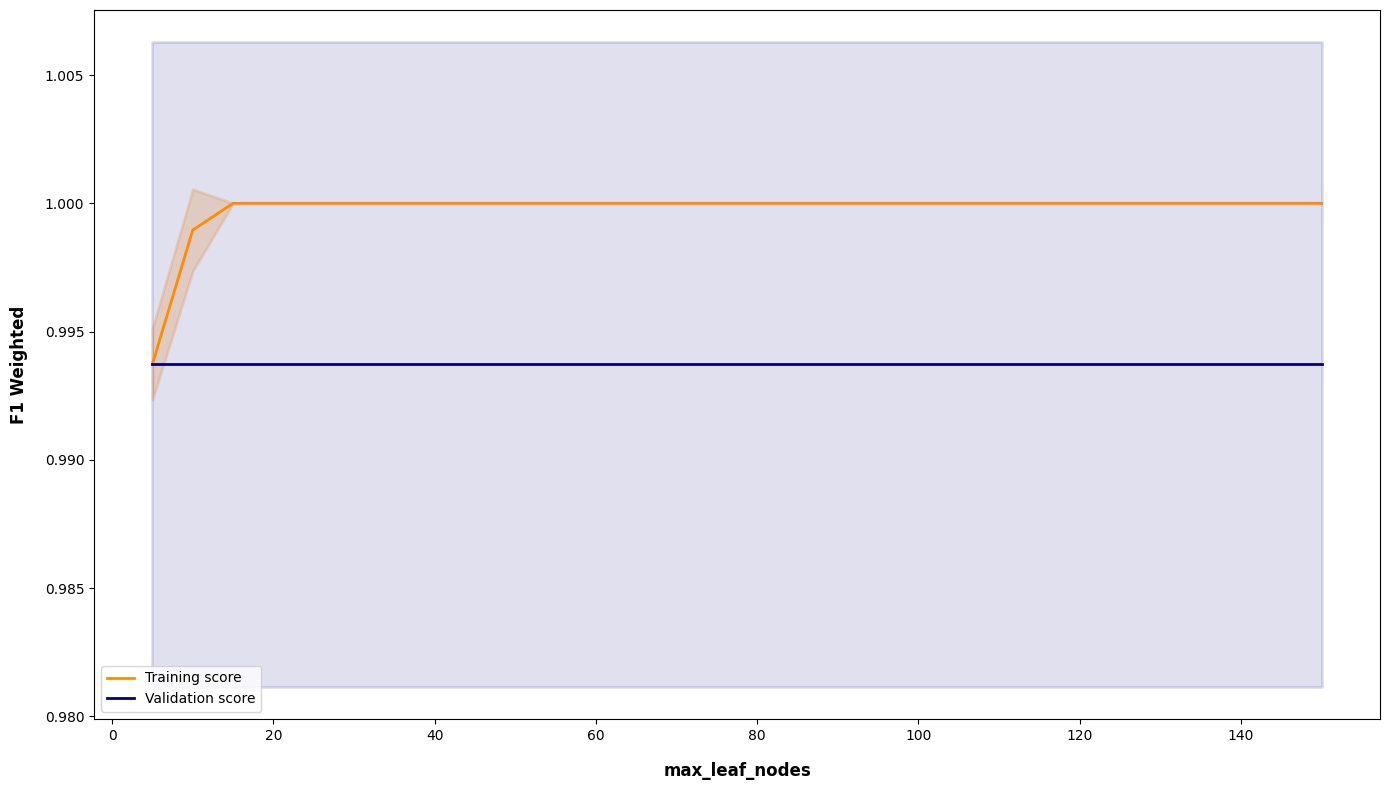

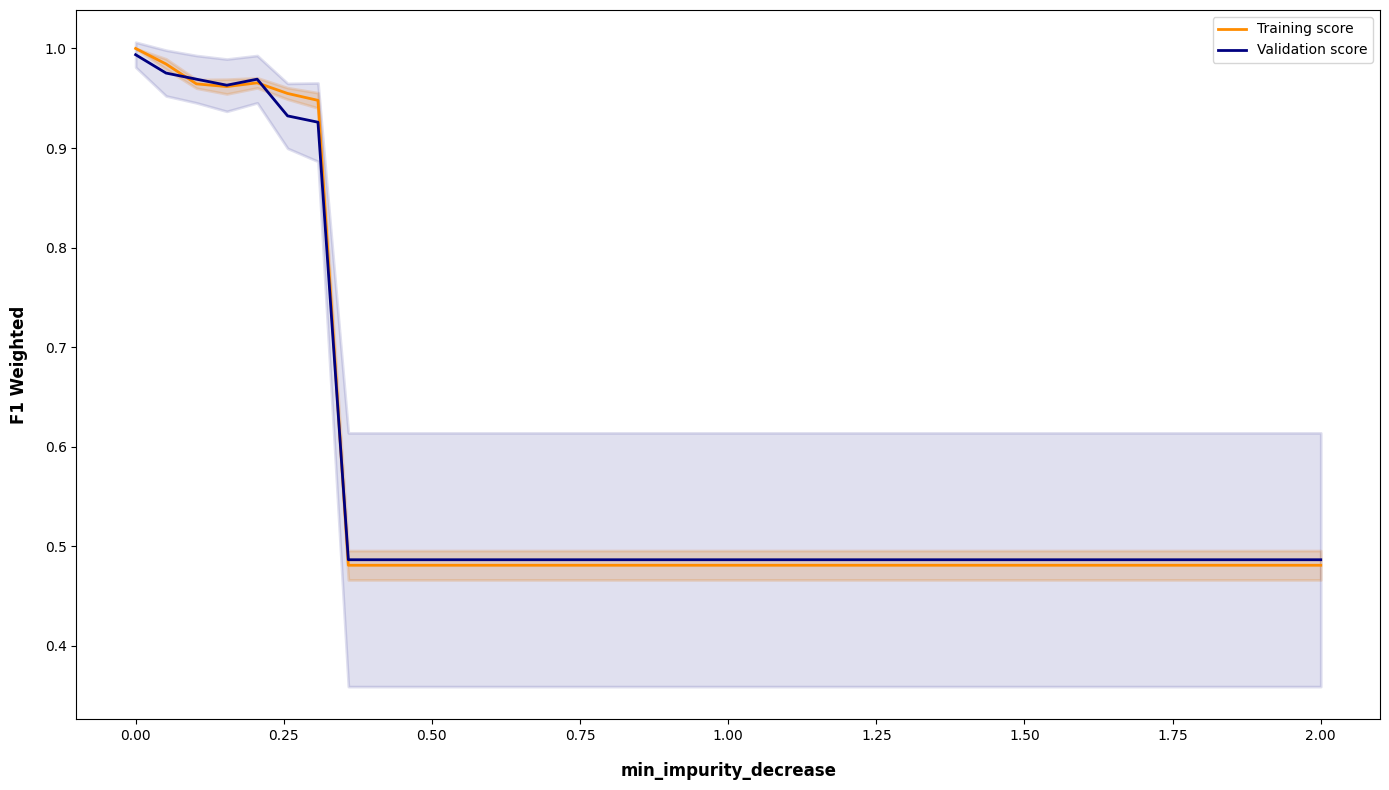

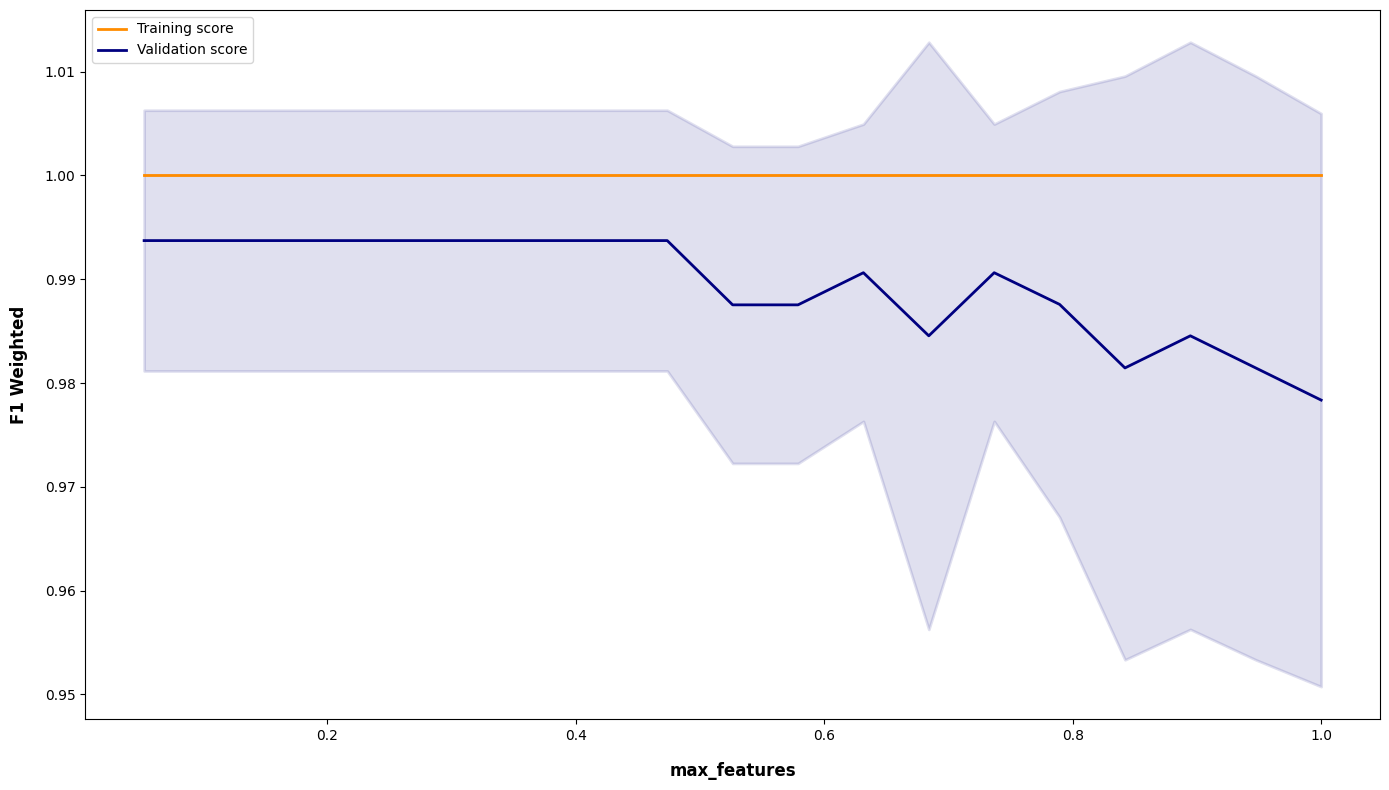

In [16]:
fig_11, ax = opt.PlotValidationCurve(RandomForestClassifier(), X_clf_rf, y_clf_rf, 'n_estimators', np.linspace(5, 120, 20, dtype=int),
                                     scoring='f1_weighted', cv=10)
fig_11.set_size_inches(14, 8)
fig_11.tight_layout()
fig_12, ax = opt.PlotValidationCurve(RandomForestClassifier(), X_clf_rf, y_clf_rf, 'max_depth', np.linspace(2, 65, 20, dtype=int),
                                     scoring='f1_weighted', cv=10)
fig_12.set_size_inches(14, 8)
fig_12.tight_layout()
fig_13, ax = opt.PlotValidationCurve(RandomForestClassifier(), X_clf_rf, y_clf_rf, 'min_samples_split', np.linspace(2, 15, 13, dtype=int),
                                     scoring='f1_weighted', cv=10)
fig_13.set_size_inches(14, 8)
fig_13.tight_layout()
fig_14, ax = opt.PlotValidationCurve(RandomForestClassifier(), X_clf_rf, y_clf_rf, 'min_samples_leaf', np.linspace(1, 20, 10, dtype=int),
                                     scoring='f1_weighted', cv=10)
fig_14.set_size_inches(14, 8)
fig_14.tight_layout()
fig_15, ax = opt.PlotValidationCurve(RandomForestClassifier(), X_clf_rf, y_clf_rf, 'min_weight_fraction_leaf', np.linspace(0, 0.5, 30),
                                     scoring='f1_weighted', cv=10)
fig_15.set_size_inches(14, 8)
fig_15.tight_layout()
fig_16, ax = opt.PlotValidationCurve(RandomForestClassifier(), X_clf_rf, y_clf_rf, 'max_leaf_nodes', np.linspace(5, 150, 30, dtype=int),
                                     scoring='f1_weighted', cv=10)
fig_16.set_size_inches(14, 8)
fig_16.tight_layout()
fig_17, ax = opt.PlotValidationCurve(RandomForestClassifier(), X_clf_rf, y_clf_rf, 'min_impurity_decrease', np.linspace(0, 2, 40),
                                     scoring='f1_weighted', cv=10)
fig_17.set_size_inches(14, 8)
fig_17.tight_layout()
fig_18, ax = opt.PlotValidationCurve(RandomForestClassifier(), X_clf_rf, y_clf_rf, 'max_features', np.linspace(0, 1, 20),
                                     scoring='f1_weighted', cv=10)
fig_18.set_size_inches(14, 8)
fig_18.tight_layout()

## Hyperparameter Selection for Grid Search

### Analysis of Validation Curves:

Based on the validation curve analysis above, we've identified the most promising hyperparameter ranges:

**max_features**:
- **Selected ranges**: top 4 - all features
- **Rationale**: These values showed the best trade-off between model performance and generalization
- Controls the randomness and diversity of trees in the forest
- Too few features can underfit; too many can lead to correlated trees

**n_estimators**:
- **Selected ranges**: 2 - 100
- **Rationale**: Performance plateaus in this range (diminishing returns beyond 80)
- Balances accuracy with computational cost
- More trees = more computation but better ensemble averaging

**max_depth**
- **Selected ranges**: 3 - no max
- **Rationale**: Performance plateaus in this range, want to see if there's any significance for the combinations.

### Next Steps:

These parameter ranges will be used in a grid search cross-validation to find the optimal combination. Grid search exhaustively tries all combinations, ensuring we find the best configuration within our defined search space.

**Why Not Include All Parameters in Grid Search?**
- Some parameters showed minimal impact on performance
- Computational cost grows exponentially with number of parameters
- Focus on parameters with the strongest influence based on validation curves
- Other parameters can use sensible defaults or be tuned in a second round if needed

## Grid Search Cross-Validation

Based on validation curve analysis, we perform exhaustive grid search over the most promising hyperparameter combinations.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid based on validation curve insights
param_grid = {
    'n_estimators': [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100],
    'max_features': ['sqrt', 4/24, 5/24, 6/24, 7/24, 1],
    'max_depth': [3, 4, 5, 10, 15, 20, 25, None],
}

print(f"Testing {np.prod([len(v) for v in param_grid.values()])} combinations with 10-fold CV")
print(f"Total model fits: {10 * np.prod([len(v) for v in param_grid.values()])}\n")

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=10,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_clf_rf, y_clf_rf)

print(f"\n{'='*70}")
print(f"BEST PARAMETERS:")
print(f"{'='*70}")
for param, value in grid_search.best_params_.items():
    print(f"  {param:25s}: {value}")
print(f"\nBest CV F1-Weighted Score: {grid_search.best_score_:.4f}")
print(f"{'='*70}")

# Analyze top configurations
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print("\n📊 Top 10 Configurations:")
display(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10))

# Check for overfitting
print(f"\n⚠️  Overfitting Check:")
print(f"Training score: {results_df.iloc[0]['mean_train_score']:.4f}")
print(f"Test score:     {results_df.iloc[0]['mean_test_score']:.4f}")
print(f"Gap:            {results_df.iloc[0]['mean_train_score'] - results_df.iloc[0]['mean_test_score']:.4f}")

Testing 528 combinations with 10-fold CV
Total model fits: 5280

Fitting 10 folds for each of 528 candidates, totalling 5280 fits

BEST PARAMETERS:
  max_depth                : 15
  max_features             : 1
  n_estimators             : 10

Best CV F1-Weighted Score: 0.9968

📊 Top 10 Configurations:


,params,mean_test_score,std_test_score,rank_test_score
453,"{'max_depth': 25, 'max_features': 1, 'n_estima...",0.996845,0.009464,1
387,"{'max_depth': 20, 'max_features': 1, 'n_estima...",0.996845,0.009464,1
321,"{'max_depth': 15, 'max_features': 1, 'n_estima...",0.996845,0.009464,1
519,"{'max_depth': None, 'max_features': 1, 'n_esti...",0.996845,0.009464,1
386,"{'max_depth': 20, 'max_features': 1, 'n_estima...",0.993743,0.012515,5
320,"{'max_depth': 15, 'max_features': 1, 'n_estima...",0.993743,0.012515,5
192,"{'max_depth': 5, 'max_features': 1, 'n_estimat...",0.993743,0.012515,5
452,"{'max_depth': 25, 'max_features': 1, 'n_estima...",0.993743,0.012515,5
518,"{'max_depth': None, 'max_features': 1, 'n_esti...",0.993743,0.012515,5
218,"{'max_depth': 10, 'max_features': 0.1666666666...",0.993690,0.012619,10



⚠️  Overfitting Check:
Training score: 0.9993
Test score:     0.9968
Gap:            0.0025


## Final Model Evaluation on Held-Out Test Set

After identifying optimal hyperparameters, we evaluate on the completely unseen test set (80 samples).

TEST SET PERFORMANCE (80 samples)

Classification Report:
              precision    recall  f1-score   support

     Not CKD     1.0000    0.9667    0.9831        30
         CKD     0.9804    1.0000    0.9901        50

    accuracy                         0.9875        80
   macro avg     0.9902    0.9833    0.9866        80
weighted avg     0.9877    0.9875    0.9875        80


📊 Confusion Matrix:
[[29  1]
 [ 0 50]]

True Negatives:   29  (Correctly identified healthy)
False Positives:   1  (Healthy misclassified as CKD)
False Negatives:   0  (CKD misclassified as healthy)
True Positives:   50  (Correctly identified CKD)

🎯 Test Set Metrics:
ROC AUC:        0.9993
Accuracy:       0.9875
F1-Weighted:    0.9875

📈 Generalization Check:
Training Accuracy: 1.0000
Test Accuracy:     0.9875
Gap:               0.0125
✅ Model generalizes well


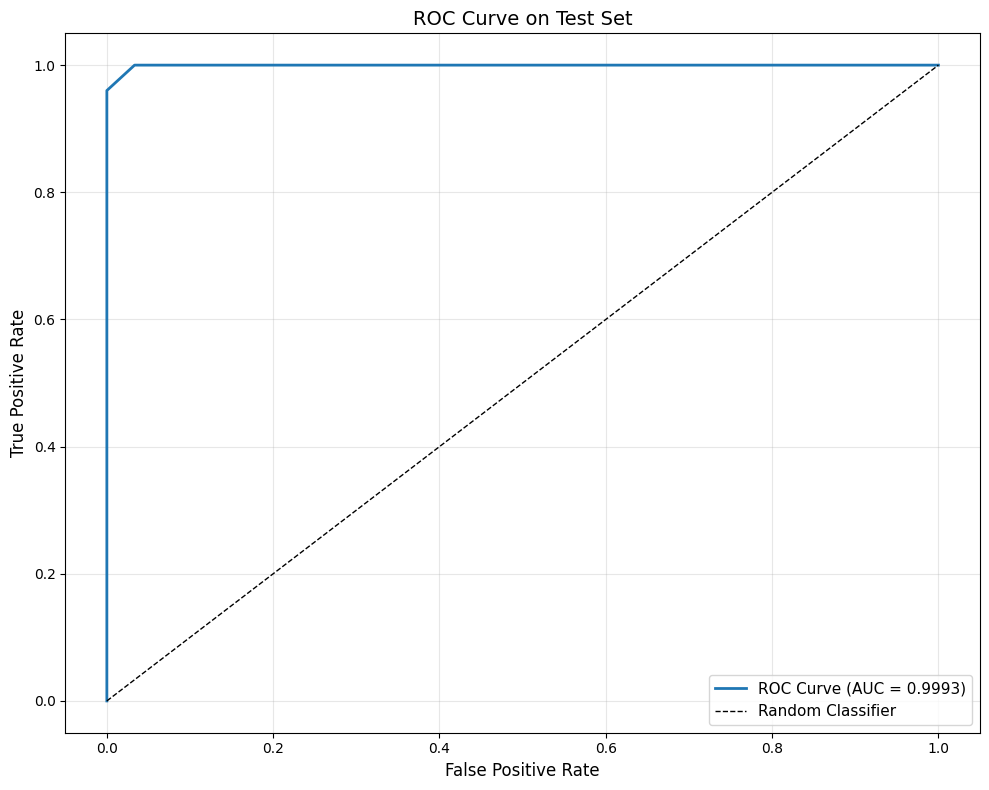

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Train final model with best parameters
best_rf = grid_search.best_estimator_

# Predictions on test set
y_pred_test = best_rf.predict(X_test_rf)
y_pred_proba = best_rf.predict_proba(X_test_rf)[:, 1]

print("="*70)
print("TEST SET PERFORMANCE (80 samples)")
print("="*70)
print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred_test,
                          target_names=['Not CKD', 'CKD'],
                          digits=4))

print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test_rf, y_pred_test)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:3d}  (Correctly identified healthy)")
print(f"False Positives: {cm[0,1]:3d}  (Healthy misclassified as CKD)")
print(f"False Negatives: {cm[1,0]:3d}  (CKD misclassified as healthy)")
print(f"True Positives:  {cm[1,1]:3d}  (Correctly identified CKD)")

print(f"\n🎯 Test Set Metrics:")
print(f"ROC AUC:        {roc_auc_score(y_test_rf, y_pred_proba):.4f}")
print(f"Accuracy:       {sklearn.metrics.accuracy_score(y_test_rf, y_pred_test):.4f}")
print(f"F1-Weighted:    {sklearn.metrics.f1_score(y_test_rf, y_pred_test, average='weighted'):.4f}")

# Compare to training performance
y_pred_train = best_rf.predict(X_clf_rf)
train_acc = sklearn.metrics.accuracy_score(y_clf_rf, y_pred_train)
test_acc = sklearn.metrics.accuracy_score(y_test_rf, y_pred_test)

print(f"\n📈 Generalization Check:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")
print(f"Gap:               {train_acc - test_acc:.4f}")

if train_acc - test_acc > 0.05:
    print("⚠️  WARNING: >5% gap suggests overfitting")
else:
    print("✅ Model generalizes well")

# ROC Curve visualization
fpr, tpr, thresholds = roc_curve(y_test_rf, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test_rf, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve on Test Set', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Appendix: Additional Analysis

This section contains supplementary analyses that provide deeper insights into model behavior and alternative approaches.

## Decision Tree Hyperparameter Validation Curves

### Why Include Decision Tree Optimization?

While Random Forest was selected as the primary model, understanding Decision Tree hyperparameters provides:

1. **Baseline Comparison**: Shows how much ensemble methods improve over single trees
2. **Interpretability Option**: If stakeholders require an explainable model, an optimized Decision Tree might be acceptable given the small performance gap
3. **Computational Efficiency**: In resource-constrained deployment scenarios (e.g., mobile devices), optimized Decision Trees offer a lightweight alternative
4. **Educational Value**: Understanding single tree behavior helps intuition about ensemble methods

### Parameters Explored:

The same hyperparameters are examined as for Random Forest (excluding n_estimators, which is specific to ensemble methods). This parallel analysis allows direct comparison of how each parameter affects simple vs. ensemble models.

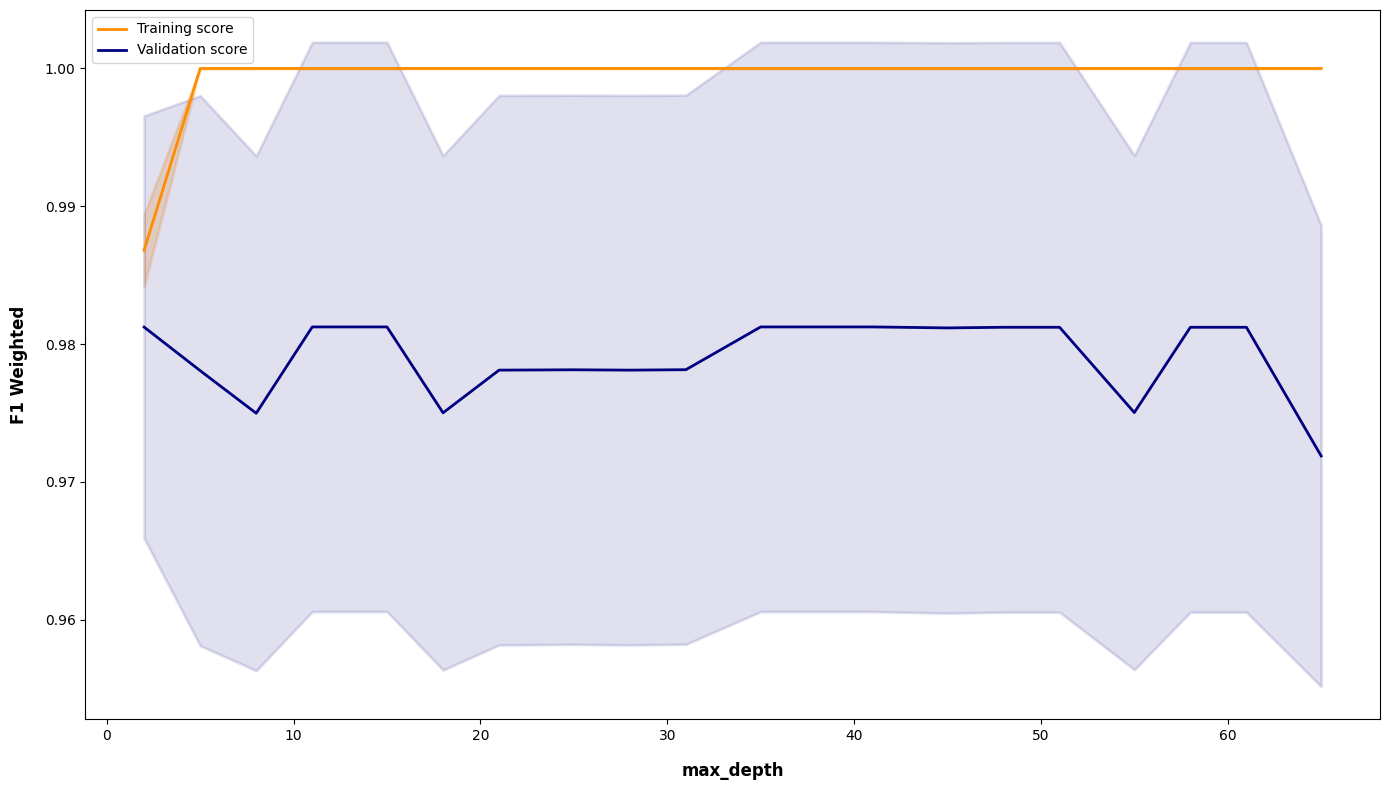

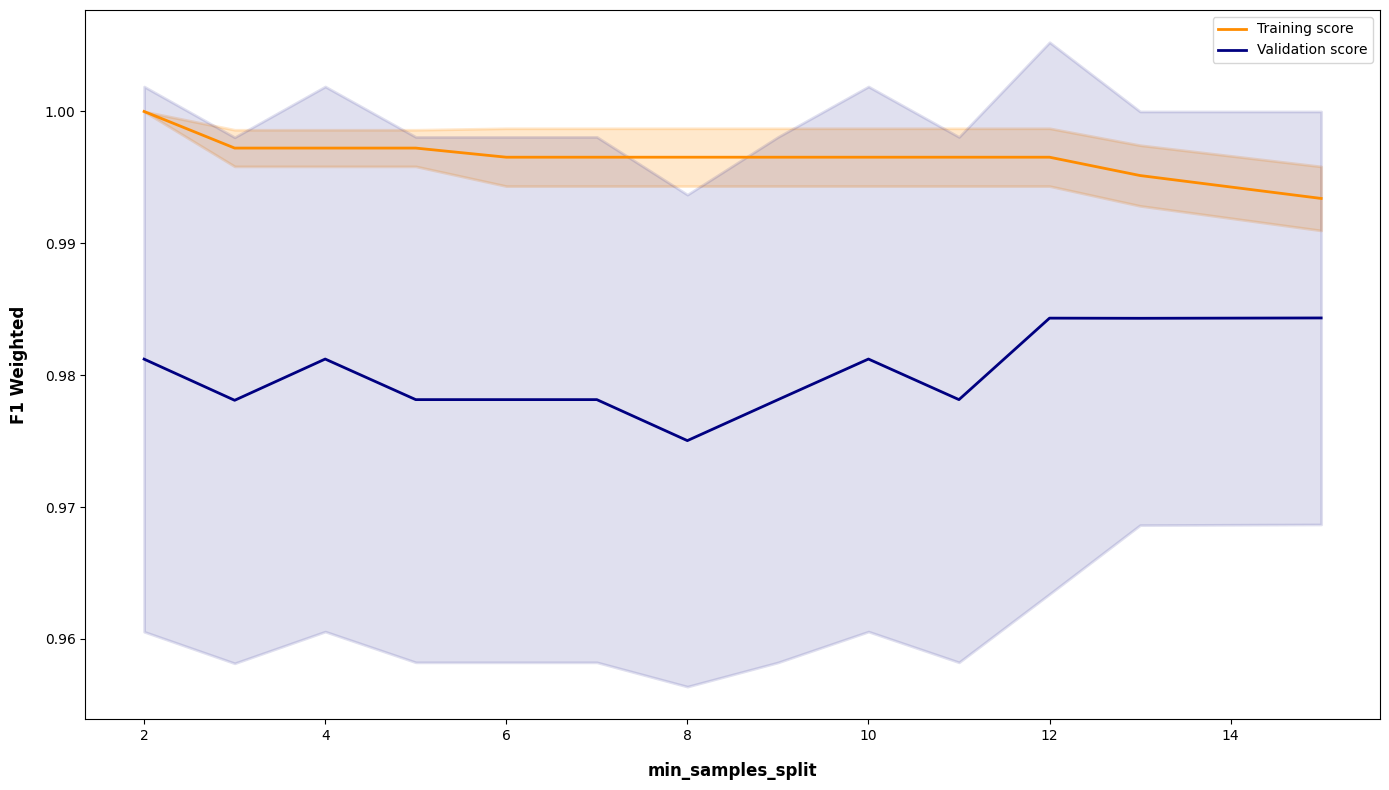

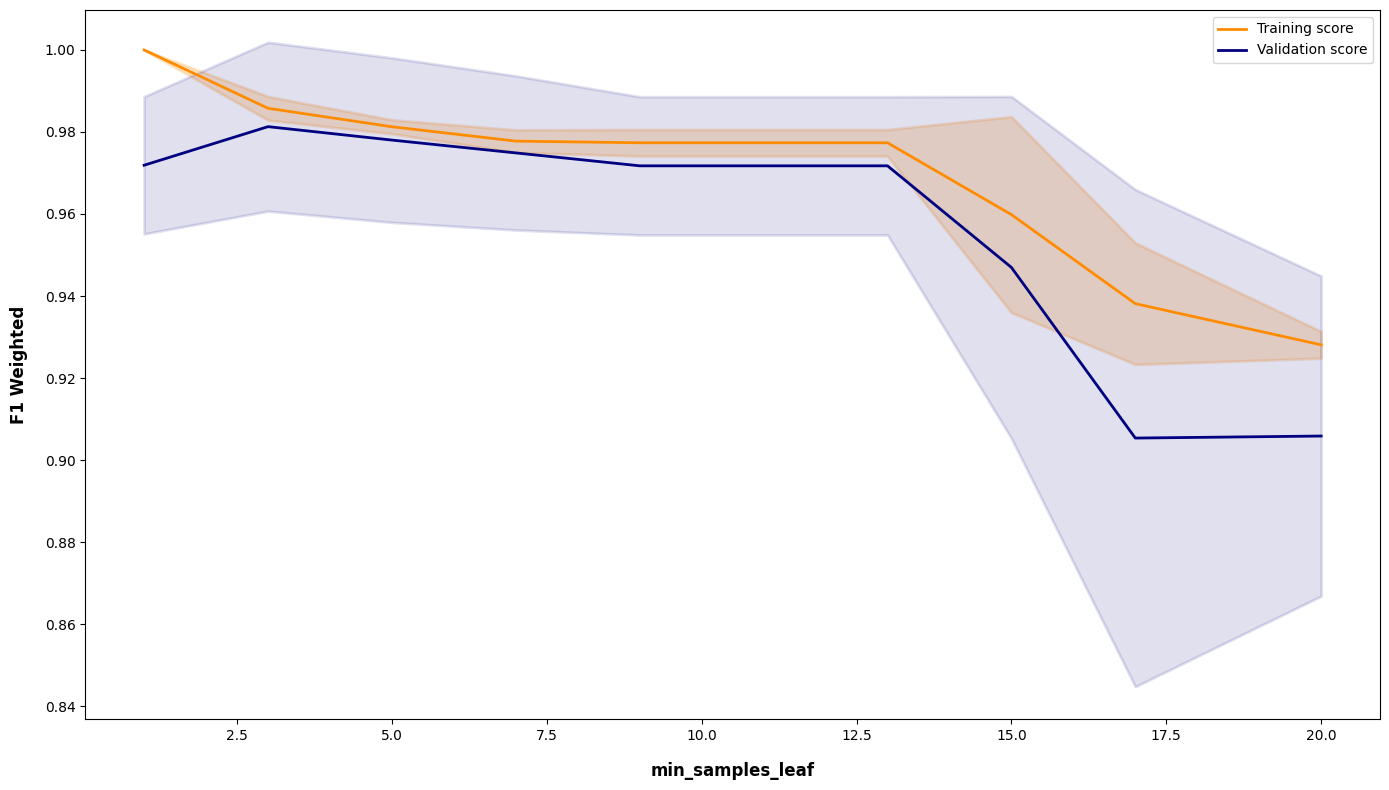

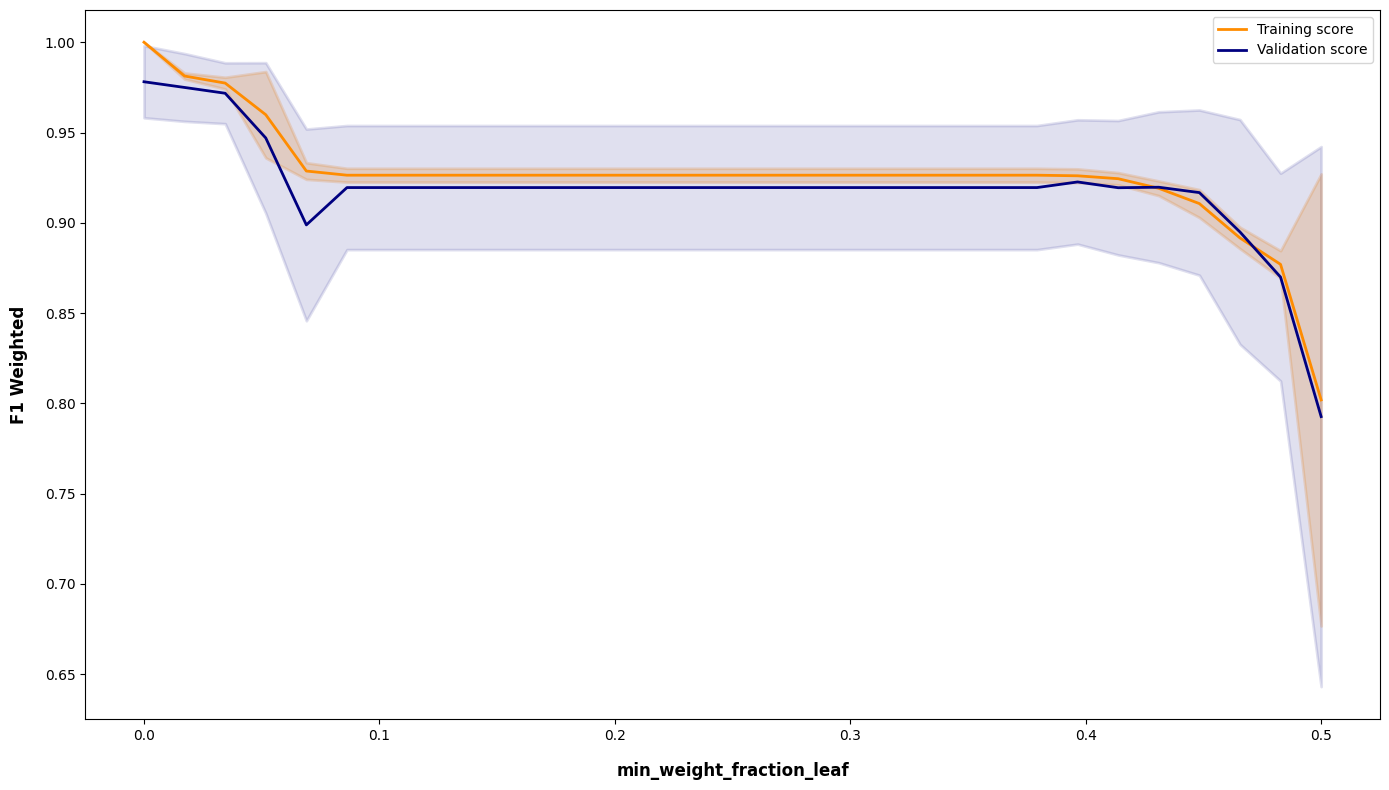

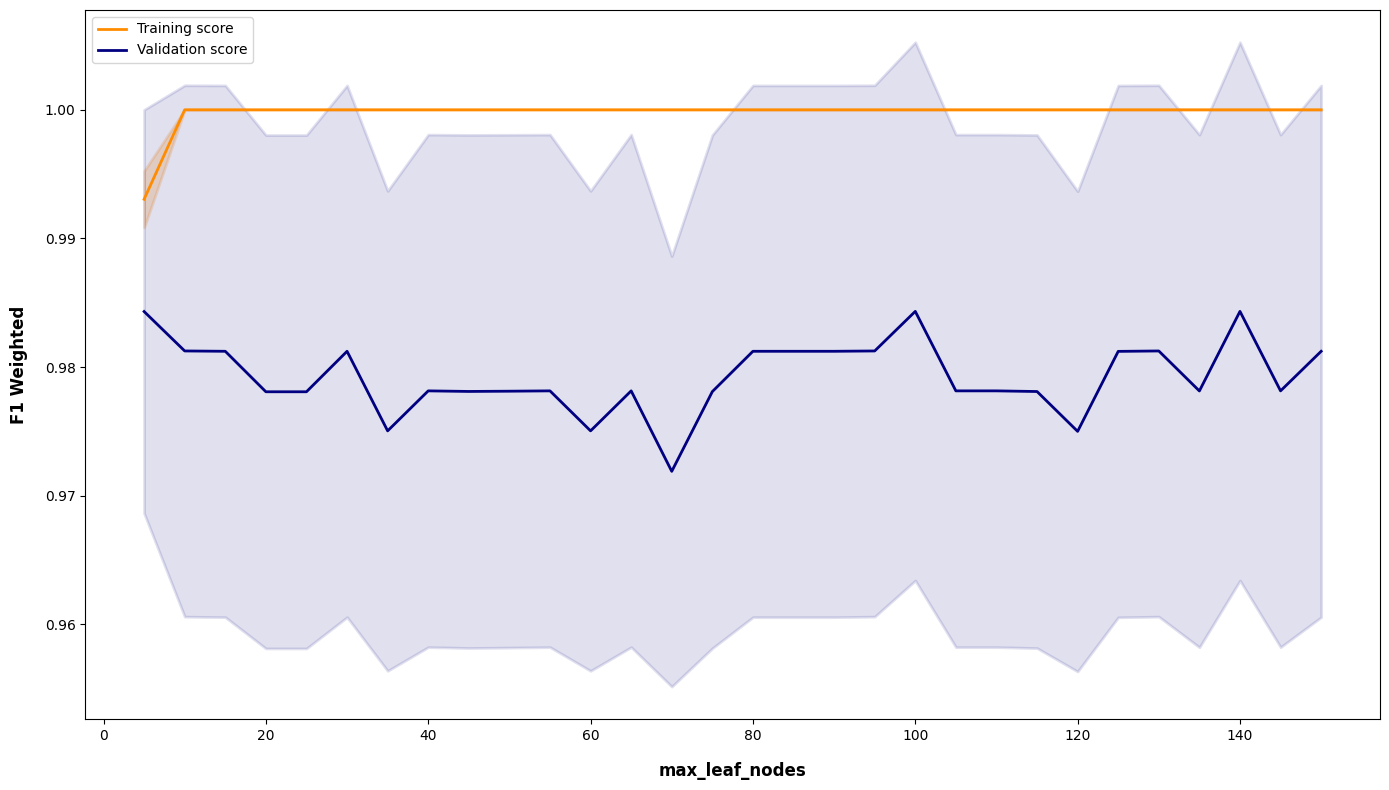

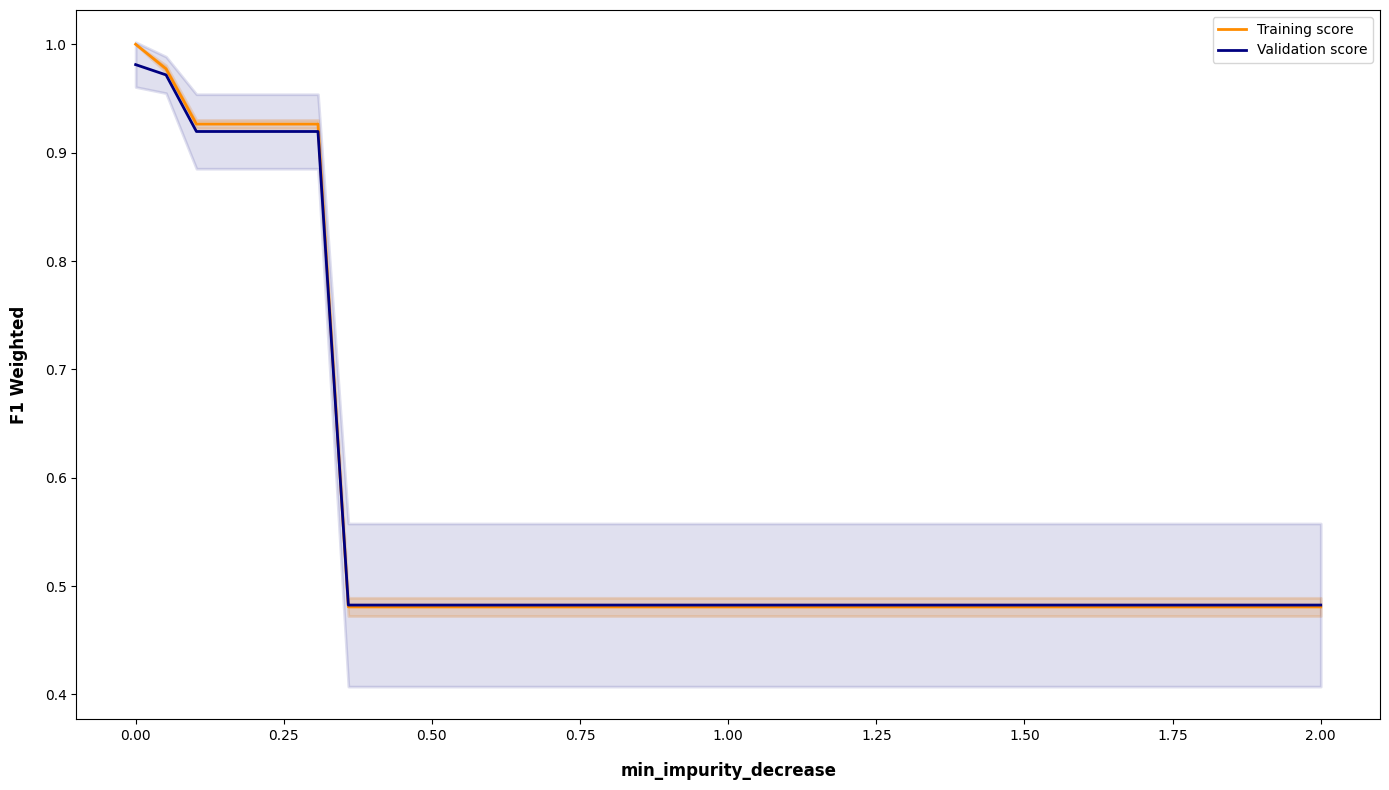

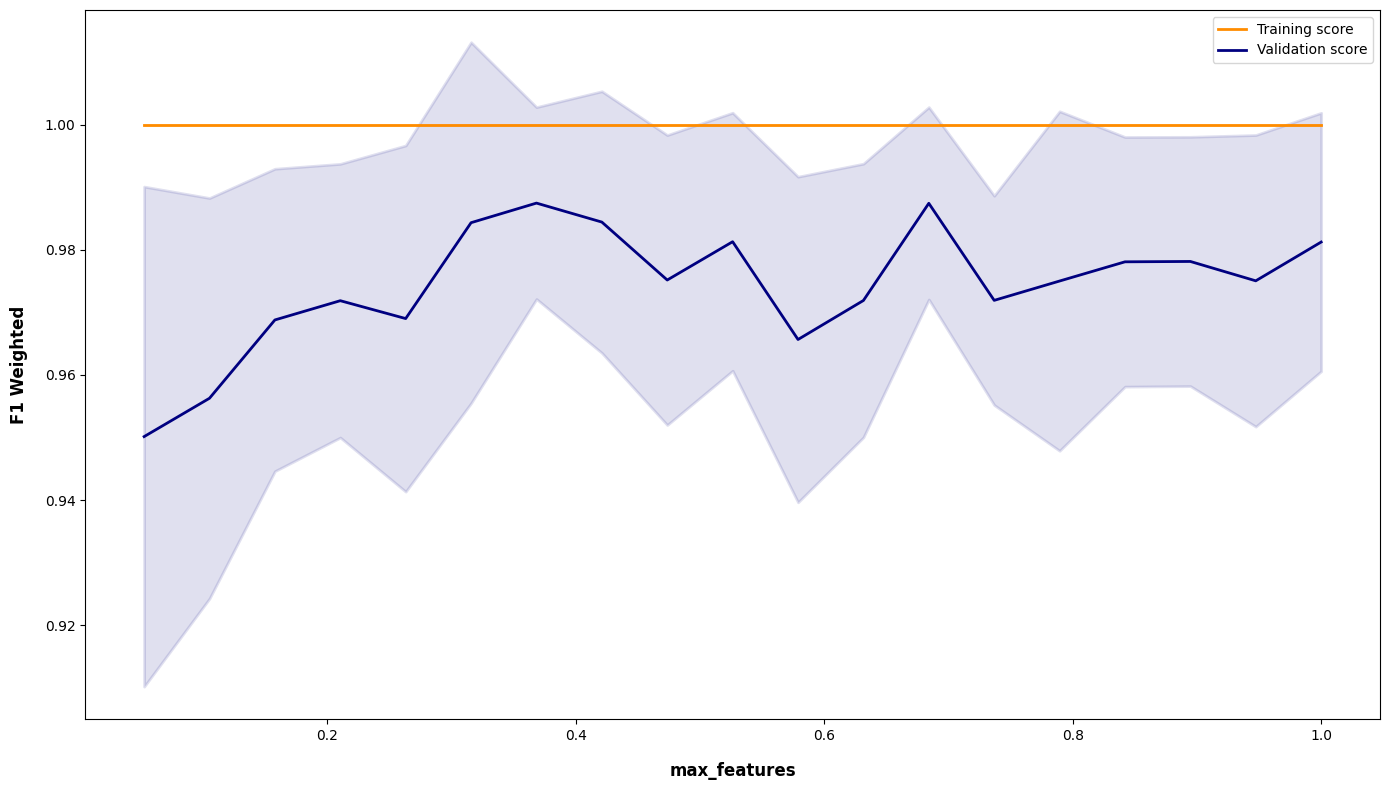

In [ ]:
fig_12, ax = opt.PlotValidationCurve(DecisionTreeClassifier(), X_clf_dt, y_clf_dt, 'max_depth', np.linspace(2, 65, 20, dtype=int),
                                     scoring='f1_weighted', cv=10)
fig_12.set_size_inches(14, 8)
fig_12.tight_layout()
fig_13, ax = opt.PlotValidationCurve(DecisionTreeClassifier(), X_clf_dt, y_clf_dt, 'min_samples_split', np.linspace(2, 15, 13, dtype=int),
                                     scoring='f1_weighted', cv=10)
fig_13.set_size_inches(14, 8)
fig_13.tight_layout()
fig_14, ax = opt.PlotValidationCurve(DecisionTreeClassifier(), X_clf_dt, y_clf_dt, 'min_samples_leaf', np.linspace(1, 20, 10, dtype=int),
                                     scoring='f1_weighted', cv=10)
fig_14.set_size_inches(14, 8)
fig_14.tight_layout()
fig_15, ax = opt.PlotValidationCurve(DecisionTreeClassifier(), X_clf_dt, y_clf_dt, 'min_weight_fraction_leaf', np.linspace(0, 0.5, 30),
                                     scoring='f1_weighted', cv=10)
fig_15.set_size_inches(14, 8)
fig_15.tight_layout()
fig_16, ax = opt.PlotValidationCurve(DecisionTreeClassifier(), X_clf_dt, y_clf_dt, 'max_leaf_nodes', np.linspace(5, 150, 30, dtype=int),
                                     scoring='f1_weighted', cv=10)
fig_16.set_size_inches(14, 8)
fig_16.tight_layout()
fig_17, ax = opt.PlotValidationCurve(DecisionTreeClassifier(), X_clf_dt, y_clf_dt, 'min_impurity_decrease', np.linspace(0, 2, 40),
                                     scoring='f1_weighted', cv=10)
fig_17.set_size_inches(14, 8)
fig_17.tight_layout()
fig_18, ax = opt.PlotValidationCurve(DecisionTreeClassifier(), X_clf_dt, y_clf_dt, 'max_features', np.linspace(0, 1, 20),
                                     scoring='f1_weighted', cv=10)
fig_18.set_size_inches(14, 8)
fig_18.tight_layout()